# Processing extracted FixMe data

In [1]:
from tabulate import tabulate
from pathlib import Path
import os
import pandas as pd
import glob
import re
import json
import git
import sqlite3
from urllib.parse import urlparse
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:

# load cve table from /Users/guru/research/FixMe/data/FixMe.db
conn = sqlite3.connect('/Users/guru/research/FixMe/data/FixMeV2.db')
df_cve = pd.read_sql_query("SELECT * FROM cve;", conn)
df_repo = pd.read_sql_query("SELECT * FROM repository;", conn)
df_hunk = pd.read_sql_query("SELECT * FROM hunk_collection;", conn)
df_patch = pd.read_sql_query("SELECT * FROM patch_collection;", conn)

print(f'CVEs shape: {df_cve.shape}')
print(f'Commit shape: {df_repo.shape}')
print(f'Patches shape: {df_patch.shape}')
print(f'Hunks shape: {df_hunk.shape}')

CVEs shape: (17481, 73)
Commit shape: (1986, 5)
Patches shape: (18484, 10)
Hunks shape: (40405, 18)


In [3]:
df_java = df_hunk[df_hunk.programming_language == 'Java'].reset_index(drop=True)
df_java.head()

,file,hunk,hunk_patch,source,target,source_lines,target_lines,added_lines,removed_lines,code_before,code_after,source_start,source_length,target_start,target_length,section_header,hunk_length,programming_language
0,hawtjni-runtime/src/main/java/org/fusesource/h...,"@@ -9,13 +9,11 @@\n *************************...","@@ -9,13 +9,11 @@\n *************************...",[' ******************************************...,[' ******************************************...,<bound method Hunk.source_lines of <Hunk: @@ 9...,<bound method Hunk.target_lines of <Hunk: @@ 9...,"['import java.io.*;\n', 'import java.util.Rand...","['import java.io.File;\n', 'import java.io.Fil...",*********************************************...,*********************************************...,9,13,9,11,,15,Java
1,hawtjni-runtime/src/main/java/org/fusesource/h...,"@@ -206,16 +204,19 @@ final public String getL...","@@ -206,16 +204,19 @@ final public String getL...",[' private boolean exractAndLoad(ArrayList...,[' private boolean exractAndLoad(ArrayList...,<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,"['\n', ' String []libNameParts = ma...","[' \n', ' \n', ' ...",private boolean exractAndLoad(ArrayList<St...,private boolean exractAndLoad(ArrayList<St...,206,16,204,19,final public String getLibraryFileName() {,23,Java
2,hawtjni-runtime/src/main/java/org/fusesource/h...,"@@ -224,8 +225,8 @@ private boolean exractAndL...","@@ -224,8 +225,8 @@ private boolean exractAndL...","[' \n', ' // Fall back...","[' \n', ' // Fall back...",<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,"[' File target = extract(errors, re...","[' File target = file(customPath, m...",\n // Fall back to extr...,\n // Fall back to extr...,224,8,225,8,private boolean exractAndLoad(ArrayList<String...,10,Java
3,hawtjni-runtime/src/main/java/org/fusesource/h...,"@@ -259,67 +260,45 @@ private String map(Strin...","@@ -259,67 +260,45 @@ private String map(Strin...","[' return libName;\n', ' }\n', ' \...","[' return libName;\n', ' }\n', ' \...",<bound method Hunk.source_lines of <Hunk: @@ 2...,<bound method Hunk.target_lines of <Hunk: @@ 2...,[' private File extract(ArrayList<String> e...,[' private boolean extract(ArrayList<String...,return libName;\n }\n\n private ...,return libName;\n }\n\n private ...,259,67,260,45,private String map(String libName) {,85,Java
4,org.springframework.web/src/main/java/org/spri...,"@@ -1,5 +1,5 @@\n /*\n- * Copyright 2002-2008 ...","@@ -1,5 +1,5 @@\n /*\n- * Copyright 2002-2008 ...","[' /*\n', '- * Copyright 2002-2008 the origina...","[' /*\n', '+ * Copyright 2002-2013 the origina...",<bound method Hunk.source_lines of <Hunk: @@ 1...,<bound method Hunk.target_lines of <Hunk: @@ 1...,[' * Copyright 2002-2013 the original author o...,[' * Copyright 2002-2008 the original author o...,/*\n * Copyright 2002-2008 the original author...,/*\n * Copyright 2002-2013 the original author...,1,5,1,5,,6,Java


Top 10 repositories with most CVEs referenced in their commits:


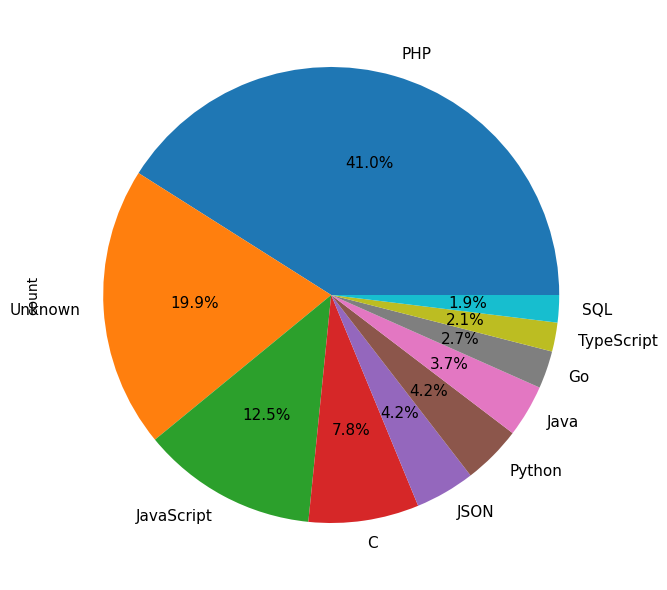

In [53]:
print('Top 10 repositories with most CVEs referenced in their commits:')
pie_chart = df_hunk.programming_language.value_counts().head(10).plot.pie(autopct='%1.1f%%',fontsize=11, figsize=(8, 6), legend=None)
plt.tight_layout()
plt.savefig('figure/top-10-pl.pdf',bbox_inches='tight', pad_inches=0.1)
plt.show()

Top 10 repositories with most CVEs referenced in their commits:


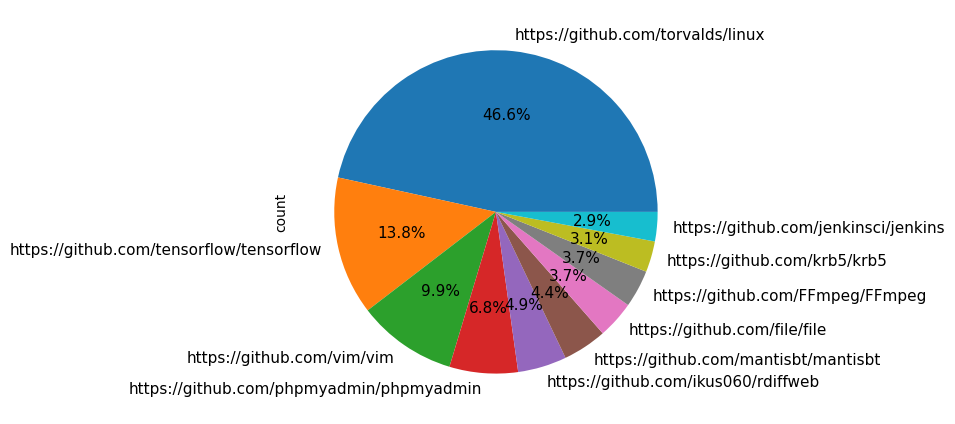

In [50]:
import matplotlib.pyplot as plt
print('Top 10 repositories with most CVEs referenced in their commits:')
pie_chart = df_repo.repo.value_counts().head(10).plot.pie(autopct='%1.1f%%',fontsize=11, figsize=(8, 6), legend=None)
plt.tight_layout()
plt.savefig('figure/top-10-repos.pdf',bbox_inches='tight', pad_inches=0.1)
plt.show()

<Axes: ylabel='Frequency'>

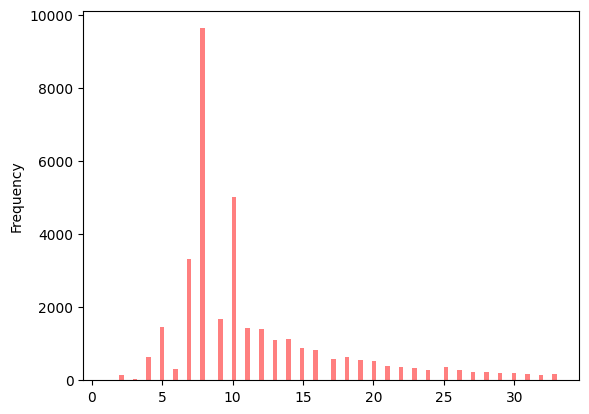

In [ ]:
# Assuming you have a pandas DataFrame called df_hunk with a column named 'hunk_length'
import pandas as pd

def remove_outliers(df, column_name):
    """
    Removes outliers from a DataFrame column using the interquartile range (IQR) method.
    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): Name of the column containing the data to filter.
    
    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    df[column_name] = df[column_name].astype(int)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]


df_filtered = remove_outliers(df_hunk, 'hunk_length')
df_filtered['hunk_length'].astype(int).plot(kind='hist', bins=100, alpha=0.5, color='r', label='hunk_length')


/var/folders/p_/9ryggq9s67zbhxhzlms6wmzw0000gn/T/ipykernel_4923/2978266235.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].astype(int)


<Axes: ylabel='Frequency'>

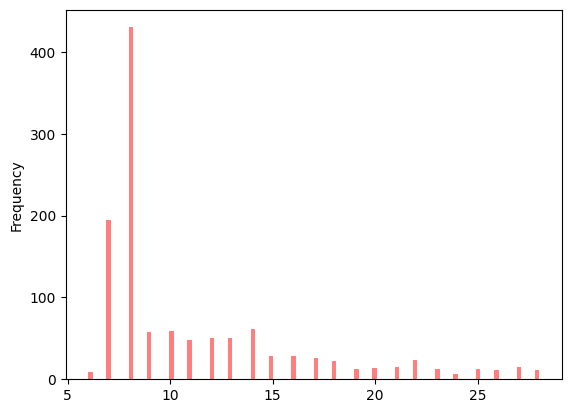

In [ ]:
df_filtered = remove_outliers(df_hunk[df_hunk.programming_language=='Java'], 'hunk_length')
df_filtered['hunk_length'].astype(int).plot(kind='hist', bins=100, alpha=0.5, color='r', label='hunk_length')

In [55]:
df_hunk[df_hunk.programming_language=='C'][['code_before', 'code_after']].reset_index(drop=True)

,code_before,code_after
0,\telse\n\t\tci->hcd = hcd;\n\n\treturn ret;\n}...,\telse\n\t\tci->hcd = hcd;\n\n\tif (ci->platda...
1,\thdr->sadb_msg_version = PF_KEY_V2;\n\thdr->s...,\thdr->sadb_msg_version = PF_KEY_V2;\n\thdr->s...
2,\thdr->sadb_msg_errno = (uint8_t) 0;\n\thdr->s...,\thdr->sadb_msg_errno = (uint8_t) 0;\n\thdr->s...
3,};\n\nstatic struct extra_reg intel_snb_extra_...,};\n\nstatic struct extra_reg intel_snb_extra_...
4,\t\tx86_pmu.event_constraints = intel_snb_even...,\t\tx86_pmu.event_constraints = intel_snb_even...
...,...,...
2856,\tdefault:\n\t\tbreak;\n\t}\n\tif (magic != NO...,\tdefault:\n\t\tbreak;\n\t}\n\tif (magic != NO...
2857,"* string, assuming that the string is utf8. ...","* string, assuming that the string is utf8. ..."
2858,void strbuf_utf8_replace(struct strbuf *sb_src...,void strbuf_utf8_replace(struct strbuf *sb_src...
2859,"void strbuf_utf8_align(struct strbuf *buf, ali...","void strbuf_utf8_align(struct strbuf *buf, ali..."


# Working for ASE2023-paper REEF 